## Data & preprocessing

Here we load the dataset, inspect it and prepare data for modelling. We start with a preliminary inspection of the dataset by which we understand its structure.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from torch import Tensor, cat
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from xrocket import XRocket
from joblib import dump, load
from matplotlib.pyplot import figure
from scipy.ndimage import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
df_train = pd.read_csv("Dataset/Normalized_sum_mean_mag_7Days_train.csv")
df_train.head()

,patient_id,dish_well,BLASTO NY,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_660,value_661,value_662,value_663,value_664,value_665,value_666,value_667,value_668,value_669
0,57,D2013.05.03_S0739_I141_1,0,0.261497,0.318247,0.364336,0.381491,0.371469,0.311635,0.258299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57,D2013.05.03_S0739_I141_2,1,0.266319,0.270286,0.282039,0.307686,0.328319,0.329314,0.313930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57,D2013.05.03_S0739_I141_3,1,0.345807,0.397308,0.429049,0.446726,0.435852,0.386693,0.354927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57,D2013.05.03_S0739_I141_4,0,0.231961,0.234204,0.263385,0.342244,0.371651,0.380495,0.362254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57,D2013.05.03_S0739_I141_5,0,0.218758,0.230684,0.238371,0.257550,0.259618,0.254286,0.247687,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# compute statistics of the dataset
df_train.describe()

,patient_id,BLASTO NY,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,...,value_660,value_661,value_662,value_663,value_664,value_665,value_666,value_667,value_668,value_669
count,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,...,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000,4246.000000
mean,412.017664,0.417334,0.341903,0.334170,0.329833,0.329166,0.323210,0.314646,0.306531,0.292268,...,0.024589,0.020910,0.018516,0.016656,0.015456,0.014373,0.013413,0.012179,0.010624,0.010448
std,242.751056,0.493177,0.262338,0.244847,0.235330,0.231270,0.218605,0.194257,0.182028,0.125038,...,0.104851,0.092788,0.089422,0.082099,0.078452,0.081400,0.074005,0.073164,0.056635,0.056199
min,1.000000,0.000000,-0.048190,-0.047787,-0.047765,-0.045874,-0.045690,-0.045540,-0.045731,-0.045833,...,-0.049893,-0.049895,-0.049896,-0.049898,-0.049901,-0.049904,-0.049907,-0.049909,-0.049909,-0.049909
25%,199.000000,0.000000,0.265516,0.262591,0.259801,0.257139,0.253171,0.250029,0.245737,0.241843,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,408.000000,0.000000,0.307407,0.305385,0.303506,0.300986,0.295542,0.291227,0.285650,0.282621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,619.000000,1.000000,0.359214,0.357375,0.353156,0.351001,0.344889,0.339319,0.332331,0.327513,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,855.000000,1.000000,4.072222,4.412415,4.422924,4.593555,4.223446,3.741807,3.356689,2.632112,...,2.427275,1.772853,1.821597,1.546798,1.471458,1.936300,1.762299,2.157444,1.027177,1.008855


In [5]:
# count the number of occurrences of each patient_id
df_count = df_train["patient_id"].value_counts()
print(df_train.shape)

(4246, 672)


Let's get a better understanding of the distribution of the classes with the plot of a bar chart.

<Axes: xlabel='BLASTO NY', ylabel='count'>

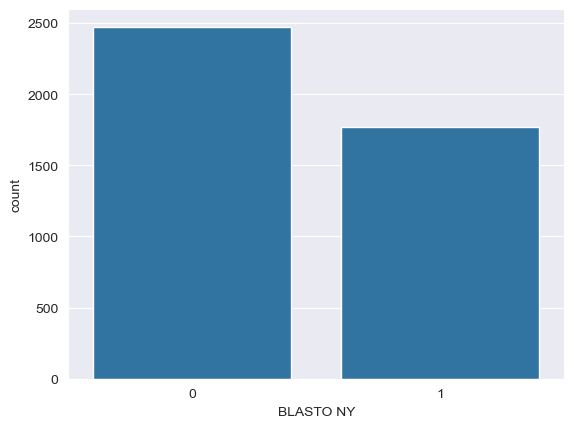

In [6]:
sns.countplot(x=df_train["BLASTO NY"])

In [7]:
# Drop the patient_id and dish_well columns
y_train = df_train["BLASTO NY"]

# drop columns
X_train =  df_train.drop(["patient_id", "dish_well", "BLASTO NY"], axis=1)
X_train.head()

,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,...,value_660,value_661,value_662,value_663,value_664,value_665,value_666,value_667,value_668,value_669
0,0.261497,0.318247,0.364336,0.381491,0.371469,0.311635,0.258299,0.236225,0.240419,0.245321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.266319,0.270286,0.282039,0.307686,0.328319,0.329314,0.313930,0.276700,0.270476,0.259795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.345807,0.397308,0.429049,0.446726,0.435852,0.386693,0.354927,0.351433,0.366438,0.379399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.231961,0.234204,0.263385,0.342244,0.371651,0.380495,0.362254,0.292565,0.274894,0.265453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.218758,0.230684,0.238371,0.257550,0.259618,0.254286,0.247687,0.234070,0.242756,0.237073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


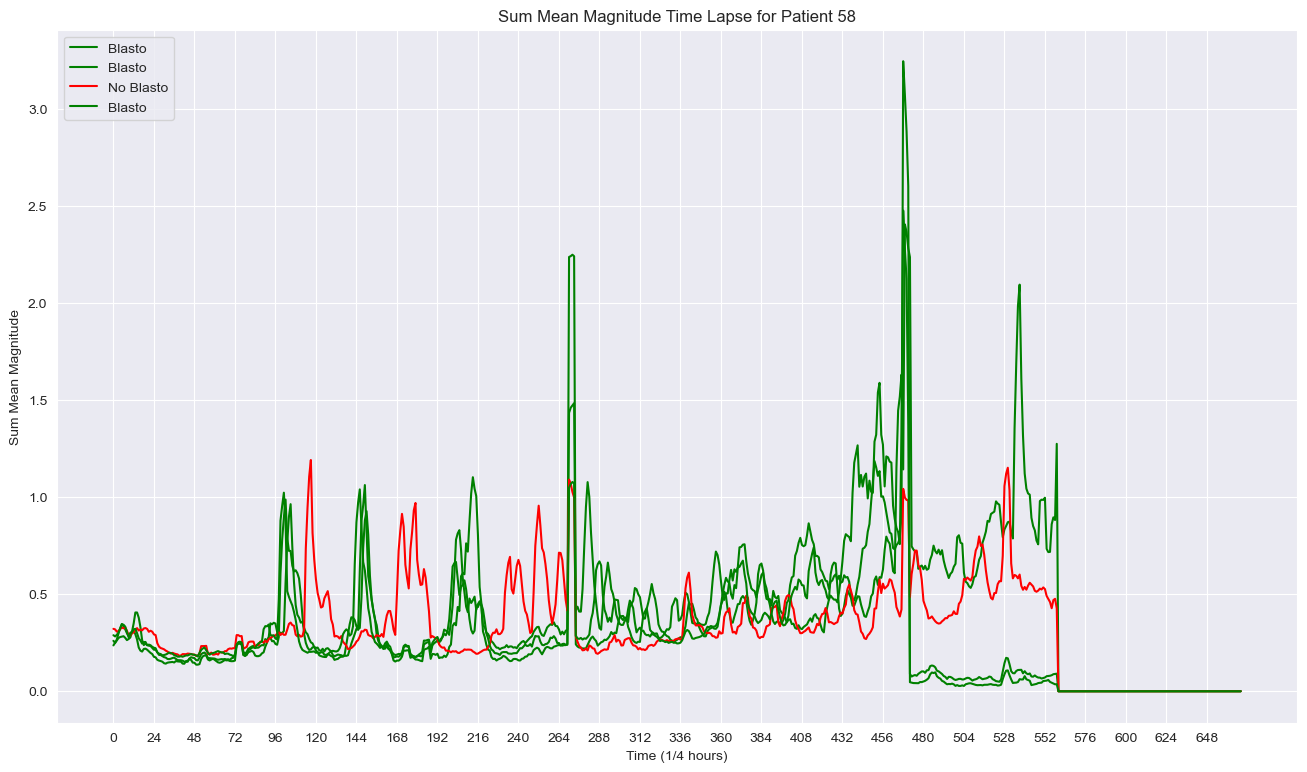

In [8]:
plt.figure(figsize=(16, 9))
# plot the first 2 rows of the dataset using lineplot
sns.lineplot(data=X_train.iloc[7].T, color="green", label="Blasto")
sns.lineplot(data=X_train.iloc[8].T, color="green", label="Blasto")
sns.lineplot(data=X_train.iloc[9].T, color="red", label="No Blasto")
sns.lineplot(data=X_train.iloc[10].T, color="green", label="Blasto")
plt.xticks(ticks=range(0, len(df_train.columns), 24), labels=range(0, len(df_train.columns), 24))
plt.legend(loc="upper left")
plt.xlabel("Time (1/4 hours)")
plt.ylabel("Sum Mean Magnitude")
plt.title(f"Sum Mean Magnitude Time Lapse for Patient 58")
# save only bounding box
plt.savefig("Dataset/Patient_58.png")
plt.show()

Because the encoder we are taking into account takes as input nparray

In [9]:
# Convert DataFrame to NumPy array
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

Upload of the Validation dataset

In [10]:
df_val = pd.read_csv("Dataset/Normalized_sum_mean_mag_7Days_val.csv")
df_val.head()

,patient_id,dish_well,BLASTO NY,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_660,value_661,value_662,value_663,value_664,value_665,value_666,value_667,value_668,value_669
0,55,D2013.03.09_S0695_I141_1,0,0.572577,0.630727,0.630506,0.624527,0.612344,0.491919,0.419470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55,D2013.03.09_S0695_I141_2,1,1.590869,0.588481,0.562928,0.675929,0.711700,0.702640,0.644273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55,D2013.03.09_S0695_I141_3,0,0.633474,0.585227,0.534210,0.537589,0.454898,0.431572,0.418882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55,D2013.03.09_S0695_I141_4,0,0.417971,0.415337,0.383101,0.409381,0.408944,0.421000,0.449001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55,D2013.03.09_S0695_I141_5,0,0.408588,0.387250,0.390963,0.396757,0.349153,0.329723,0.315952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Drop the patient_id and dish_well columns
y_val = df_val["BLASTO NY"]
# remove also the last 3 columns (they are all zeros)
X_val =  df_val.drop(["patient_id", "dish_well", "BLASTO NY"], axis=1)

In [12]:
# Convert DataFrame to NumPy array
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()

In [13]:
# Append validation set to training set
X_combined = np.concatenate([X_train_np, X_val_np])
y_combined = np.concatenate([y_train_np, y_val_np])

# Convert combined data to NumPy arrays if needed
X_train_np = X_combined
y_train_np = y_combined

print(X_train_np.shape, y_train_np.shape)

(5118, 669) (5118,)


In [14]:
# Raggruppa per 'patient_id' e conta il numero di 'dish_well' per ciascun paziente
dish_well_counts = df_train.groupby('patient_id')['dish_well'].size()

min_dish_well = dish_well_counts.min()
max_dish_well = dish_well_counts.max()
avg_dish_well = dish_well_counts.mean()
std_dish_well = dish_well_counts.std()
print(min_dish_well, max_dish_well, avg_dish_well, std_dish_well)

# count the number of patients
patients = df_train['patient_id'].unique()
print(patients.shape)


1 12 7.283018867924528 3.2576375726323947
(583,)


Upload of the Test set

In [15]:
df_test = pd.read_csv("Dataset/Normalized_sum_mean_mag_7Days_test.csv")
df_test.head()

,patient_id,dish_well,BLASTO NY,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_660,value_661,value_662,value_663,value_664,value_665,value_666,value_667,value_668,value_669
0,54,D2013.02.19_S0675_I141_1,1,0.453090,0.486254,0.491589,0.480789,0.463109,0.396335,0.354484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54,D2013.02.19_S0675_I141_2,1,0.336271,0.348036,0.317212,0.337589,0.369267,0.336308,0.340676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54,D2013.02.19_S0675_I141_3,0,0.378551,0.372837,0.381751,0.397863,0.384040,0.397442,0.418591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54,D2013.02.19_S0675_I141_4,0,0.359671,0.332475,0.321837,0.330938,0.327185,0.328848,0.320618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54,D2013.02.19_S0675_I141_5,1,0.378254,0.333187,0.317179,0.294908,0.292819,0.302114,0.309026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Drop the patient_id and dish_well columns
y_test = df_test["BLASTO NY"]

X_test =  df_test.drop(["patient_id", "dish_well", "BLASTO NY"], axis=1)
print(X_test.shape)

(929, 669)


In [17]:
# Convert DataFrame to NumPy array
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [18]:
# Raggruppa per 'patient_id' e conta il numero di 'dish_well' per ciascun paziente
dish_well_counts = df_test.groupby('patient_id')['dish_well'].size()

min_dish_well = dish_well_counts.min()
max_dish_well = dish_well_counts.max()
avg_dish_well = dish_well_counts.mean()
std_dish_well = dish_well_counts.std()
print(min_dish_well, max_dish_well, avg_dish_well, std_dish_well)

# count the number of patients
patients = df_test['patient_id'].unique()
print(patients.shape)

1 17 7.373015873015873 3.27593437537232
(126,)


## Perform a classification using standard features and Decision Tree

In [20]:
# Initialize the RandomForestClassifier
model_bf_dt = DecisionTreeClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model_bf_dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(X_train_np, y_train_np)

# Get the cross-validation scores
cv_scores_bf_dt = grid_search.cv_results_['mean_test_score']

# Get the best model
best_model_bf_dt = grid_search.best_estimator_

# Print cross-validation scores and the best model
print("Cross-validation scores:", cv_scores_bf_dt)
print("Best model:", best_model_bf_dt)

Cross-validation scores: [0.85346121 0.84545092 0.85365748 0.84701456 0.83744272 0.84056944
 0.84701456 0.84212908]
Best model: DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)


Accuracy: 0.8902045209903121
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       523
           1       0.90      0.84      0.87       406

    accuracy                           0.89       929
   macro avg       0.89      0.88      0.89       929
weighted avg       0.89      0.89      0.89       929



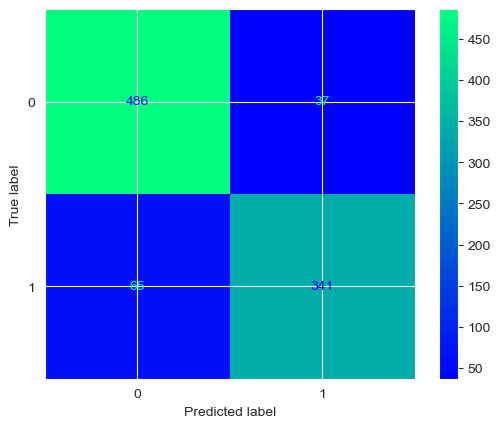

In [23]:
# predict the classes
pred_bf_dt_test = best_model_bf_dt.predict(X_test_np)
acc_bf_dt_test = accuracy_score(y_test_np, pred_bf_dt_test)
print("Accuracy:", accuracy_score(y_test_np, pred_bf_dt_test))
print("Classification Report:\n", classification_report(y_test_np, pred_bf_dt_test))
conf_matrix_bf_rf_test = confusion_matrix(y_test_np, pred_bf_dt_test)
p = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bf_rf_test)
p.plot(cmap='winter')

In [33]:
report_dt = classification_report(y_test_np, pred_bf_dt_test, output_dict=True)
df_report_dt = pd.DataFrame(report_dt).transpose()

# Converte il DataFrame in formato LaTeX
latex_report = df_report_dt.to_latex()

# Stampa il report in formato LaTeX
print(latex_report)

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
0 & 0.882033 & 0.929254 & 0.905028 & 523.000000 \\
1 & 0.902116 & 0.839901 & 0.869898 & 406.000000 \\
accuracy & 0.890205 & 0.890205 & 0.890205 & 0.890205 \\
macro avg & 0.892075 & 0.884578 & 0.887463 & 929.000000 \\
weighted avg & 0.890810 & 0.890205 & 0.889675 & 929.000000 \\
\bottomrule
\end{tabular}



## Perform a classification using standard features and Random Forest

In [58]:
# Initialize the RandomForestClassifier
model_bf_rf = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model_bf_rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(X_train_np, y_train_np)

# Get the cross-validation scores
cv_scores_sf_rf = grid_search.cv_results_['mean_test_score']

# Get the best model
best_model_bf_rf = grid_search.best_estimator_

# Print cross-validation scores and the best model
print("Cross-validation scores:", cv_scores_sf_rf)
print("Best model:", best_model_bf_rf)

Cross-validation scores: [0.90719372 0.90562931 0.90758473 0.90582692 0.90426213 0.90563027
 0.90445725 0.90524098 0.90777871 0.90973298 0.90738904 0.90914761
 0.90778004 0.90777928 0.90563065 0.90738846]
Best model: RandomForestClassifier(max_depth=20, n_estimators=200)


Accuracy: 0.8826695371367062
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       523
           1       0.88      0.85      0.86       406

    accuracy                           0.88       929
   macro avg       0.88      0.88      0.88       929
weighted avg       0.88      0.88      0.88       929



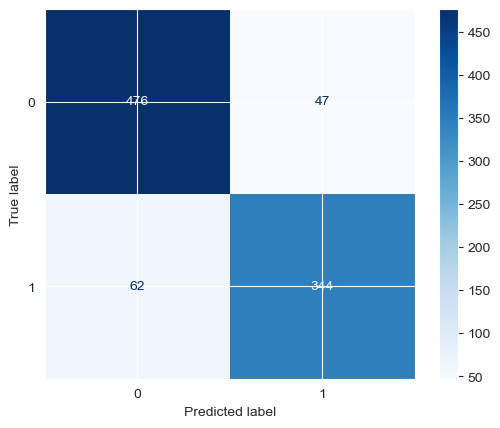

In [41]:
# predict the classes
pred_bf_rf_test = best_model_bf_rf.predict(X_test_np)
acc_bf_rf_test = accuracy_score(y_test_np, pred_bf_rf_test)
print("Accuracy:", accuracy_score(y_test_np, pred_bf_rf_test))
print("Classification Report:\n", classification_report(y_test_np, pred_bf_rf_test))
conf_matrix_bf_rf_test = confusion_matrix(y_test_np, pred_bf_rf_test)
p = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bf_rf_test)
p.plot(cmap='Blues')
# Salva il grafico su file
plt.savefig('confusion_matrix.png')
#

In [ ]:
report_rf = classification_report(y_test_np, pred_bf_dt_test, output_dict=True)
df_report_rf = pd.DataFrame(report_rf).transpose()

# Converte il DataFrame in formato LaTeX
latex_report = df_report_rf.to_latex()

# Stampa il report in formato LaTeX
print(latex_report)

In [60]:
# Save the Random Forest model
dump(best_model_bf_rf, 'models/model_bf_rf.joblib')

['models/model_bf_rf.joblib']

## SHapley Additive exPlanations
SHAP is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

In [61]:
# Create a SHAP object by using TreeExplainer
explainer = shap.TreeExplainer(best_model_bf_rf)

In [62]:
# Calculate SHAP values for the training
shap_values_train = explainer.shap_values(X_train_np)

In [63]:
# Check if shap_values has the correct shape
print("SHAP values (train) shape:", np.array(shap_values_train).shape)
print("X_train shape:", X_train_np.shape)

SHAP values (train) shape: (5118, 669, 2)
X_train shape: (5118, 669)


## SHAP Summary Plot

This plot gives a global overview of how the features in the dataset are influencing the model’s predictions — specifically for class 0 (“no blastocyst”).

Vertical axis: Lists features in descending order of importance — meaning, those at the top contribute the most (positively or negatively) to your model’s decision.

Each dot: Represents a single sample (i.e., a patient’s data point for a specific day), placed along the x-axis according to how much that particular feature influenced the prediction for that case.

Color gradient: Shows the original value of that feature for that sample (e.g., red = high, blue = low).

X-axis: SHAP values, which tell you the direction and strength of influence on the model’s output. Values far from zero (left or right) indicate strong influence.

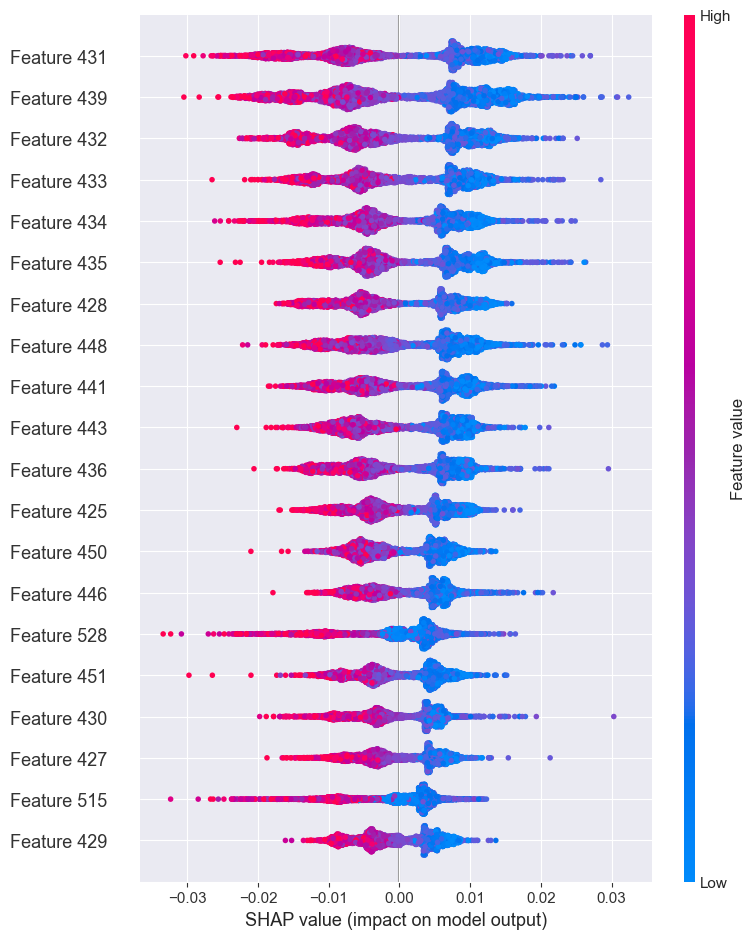

In [64]:
# Assuming 'shap_values_train' and 'X_train_np' are already calculated
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_train[:, :, 0], X_train_np)

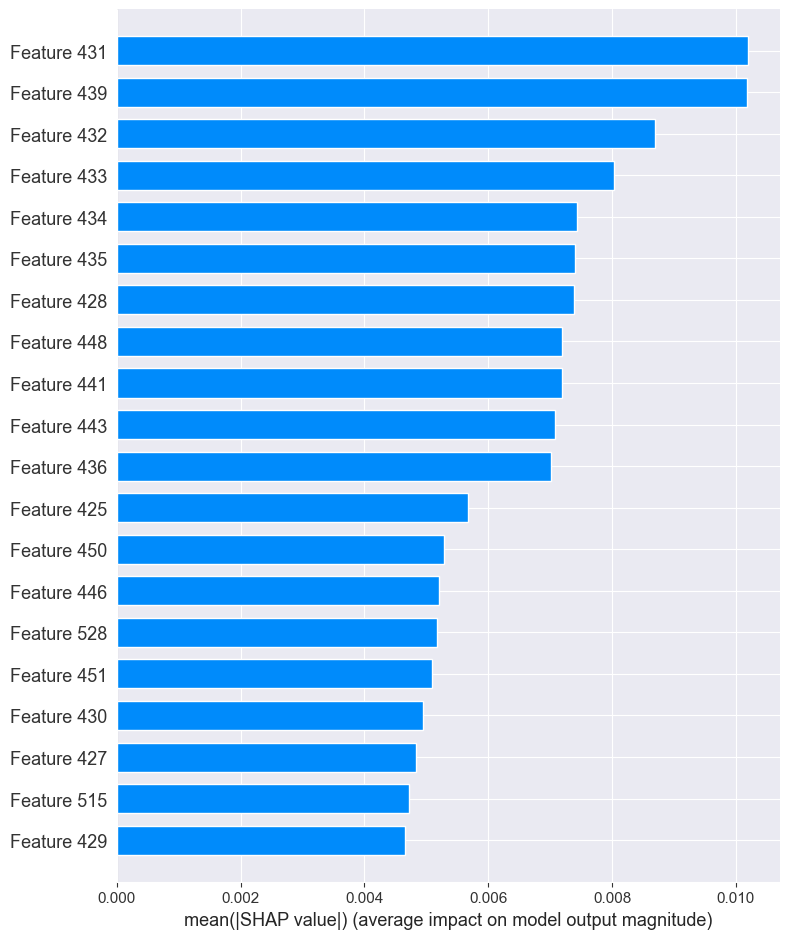

In [65]:
# Plot SHAP bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_train[:, :, 0], X_train_np, plot_type='bar')

## SHAP Decision Plot

This plot is a step-by-step breakdown of the prediction for a specific instance (again, a patient), showing how each feature contributed to the final decision.

X-axis: The SHAP value accumulating over features — essentially, the model’s output building up as more information (features) is considered.

Y-axis: Each feature that contributed significantly to the decision, ordered by when it entered the path.

Flat sections mean the feature had little to no impact on the prediction; steep slopes mean strong influence.

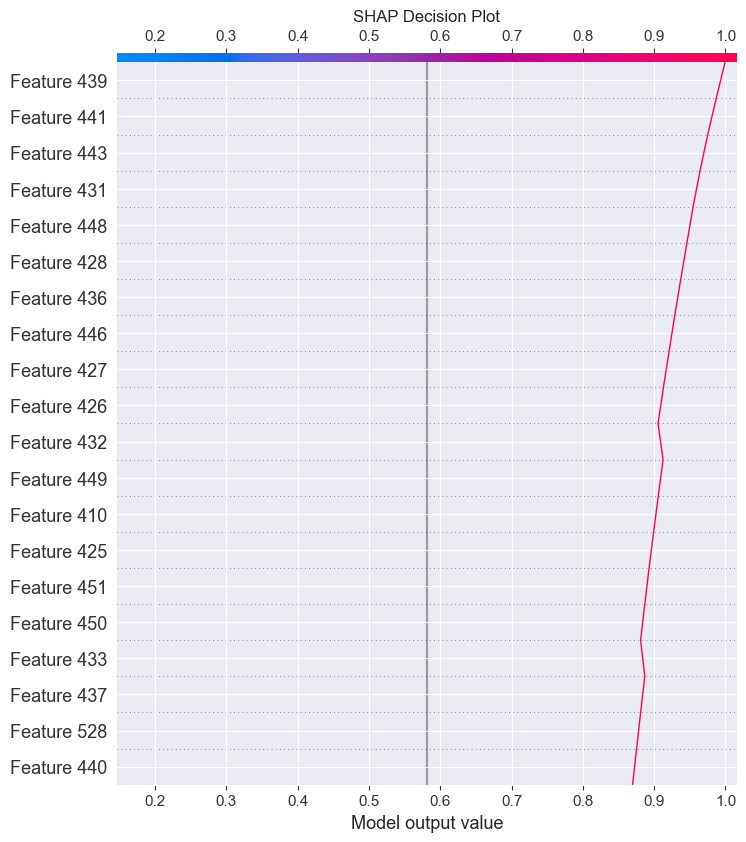

In [66]:
new_shap_values_train = shap_values_train[:, :, 0]
plt.title("SHAP Decision Plot")
shap.decision_plot(explainer.expected_value[0], new_shap_values_train[0][:])

In [115]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the feature names
feature_names = list(X_train.columns)

# Class names
class_names = ["BLASTO NY", "NO BLASTO NY"]

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_np, feature_names=feature_names, class_names=class_names, mode='classification')

# Function to explain an instance
def explain_instance(instance):
    exp = explainer.explain_instance(instance, best_model_bf_rf.predict_proba, num_features=10)
    return exp

# Apply the function to each instance in the dataset
explanations = [explain_instance(instance) for instance in X_train_np]

# Display the explanations
for exp in explanations:
    exp.show_in_notebook(show_table=True)

KeyboardInterrupt: 

## X-ROCKET encoder


In [68]:
# Convert NumPy array to PyTorch tensor
X_train_tensor = Tensor(X_train_np)
X_test_tensor = Tensor(X_test_np)

In [69]:
# Encode the entire dataset
encoder = XRocket(in_channels=1, max_kernel_span=100, combination_order=1, feature_cap=1008)
encoder.fit(X_train_tensor[0].unsqueeze(0).unsqueeze(0))
encoder.fit(X_test_tensor[0].unsqueeze(0).unsqueeze(0))

In [70]:
# Embed the dataset
embed_train = [encoder(x.unsqueeze(0).unsqueeze(0)) for x in X_train_tensor]
embed_test = [encoder(x.unsqueeze(0).unsqueeze(0)) for x in X_test_tensor]

In [71]:
# Convert the list of tensors to a single tensor
embed_train_tensor = cat(embed_train)
embed_test_tensor = cat(embed_test)

In [72]:
feature_names = pd.Index(encoder.feature_names).rename(["pattern", "dilation", "channel", "threshold"])
embed_train_df = pd.DataFrame(data=embed_train_tensor.numpy(), columns=feature_names)
embed_test_df = pd.DataFrame(data=embed_test_tensor.numpy(), columns=feature_names)
print(feature_names.names)

In [116]:
embed_train_df.to_csv("Dataset/dataset_XRocket_app.csv", index=False)

## Prediction head (Random Forest Classifier)

In [74]:
# Initialize the RandomForestClassifier
model_rf = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(embed_train_df, y_train_np)

# Get the cross-validation scores
cv_scores_rf = grid_search.cv_results_['mean_test_score']

# Get the best model
best_model_rf = grid_search.best_estimator_

# Print cross-validation scores and the best model
print("Cross-validation scores:", cv_scores_rf)
print("Best model:", best_model_rf)

Cross-validation scores: [0.87299724 0.87084842 0.87416968 0.87104296 0.87319274 0.87338748
 0.87417026 0.87241225 0.87475696 0.87319331 0.87182593 0.87084784
 0.87280116 0.8751472  0.87495189 0.87514567]
Best model: RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200)


In [75]:
# predict the classes
pred_rf_train = best_model_rf.predict(embed_train_df)
acc_rf_train = accuracy_score(y_train_np, pred_rf_train)

In [76]:
print("Accuracy:", accuracy_score(y_train_np, pred_rf_train))
print("Classification Report:\n", classification_report(y_train_np, pred_rf_train))

Accuracy: 0.9960922235248144
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2970
           1       1.00      0.99      1.00      2148

    accuracy                           1.00      5118
   macro avg       1.00      1.00      1.00      5118
weighted avg       1.00      1.00      1.00      5118



[[2963    7]
 [  13 2135]]


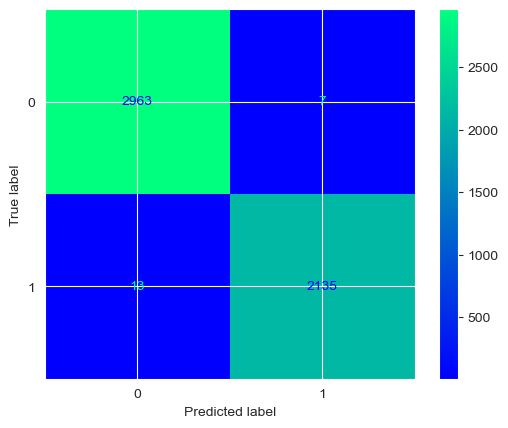

In [77]:
conf_matrix_rf_train = confusion_matrix(y_train_np, pred_rf_train)
print(conf_matrix_rf_train)
p = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_train)
p.plot(cmap='winter')

In [78]:
# predict the classes
pred_rf_test = best_model_rf.predict(embed_test_df)
acc_rf_test = accuracy_score(y_test_np, pred_rf_test)

In [79]:
print("Accuracy:", accuracy_score(y_test_np, pred_rf_test))
print("Classification Report:\n", classification_report(y_test_np, pred_rf_test))

Accuracy: 0.8966630785791173
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       523
           1       0.88      0.89      0.88       406

    accuracy                           0.90       929
   macro avg       0.89      0.90      0.90       929
weighted avg       0.90      0.90      0.90       929



[[472  51]
 [ 45 361]]


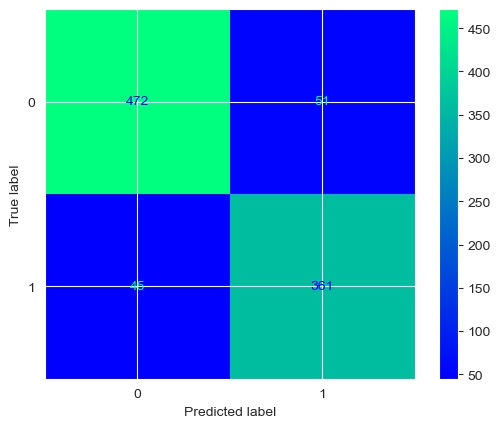

In [80]:
conf_matrix_rf_test = confusion_matrix(y_test_np, pred_rf_test)
print(conf_matrix_rf_test)
p = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_test)
p.plot(cmap='winter')

In [ ]:
report_rf_xr = classification_report(y_test_np, pred_rf_test, output_dict=True)
df_report_rf_xr = pd.DataFrame(report_rf_xr).transpose()

# Converte il DataFrame in formato LaTeX
latex_report = df_report_rf_xr.to_latex()

# Stampa il report in formato LaTeX
print(latex_report)

In [81]:
# Save the Random Forest model
dump(best_model_rf, 'models/model_XRocket_rf.joblib')

['models/model_XRocket_rf.joblib']

## Feature importances (Random Forest Classifier)

In [82]:
feature_importances_rf = pd.Series(data=best_model_rf.feature_importances_, index=feature_names)
print(feature_importances_rf)

pattern                                              dilation  channel  threshold
[2.0, 2.0, 2.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]  1         [1.0]    0.0150       0.000768
[2.0, 2.0, -1.0, 2.0, -1.0, -1.0, -1.0, -1.0, -1.0]  1         [1.0]    0.0126       0.000652
[2.0, 2.0, -1.0, -1.0, 2.0, -1.0, -1.0, -1.0, -1.0]  1         [1.0]    0.0079       0.000416
[2.0, 2.0, -1.0, -1.0, -1.0, 2.0, -1.0, -1.0, -1.0]  1         [1.0]    0.0049       0.000388
[2.0, 2.0, -1.0, -1.0, -1.0, -1.0, 2.0, -1.0, -1.0]  1         [1.0]    0.0035       0.000290
                                                                                       ...   
[-1.0, -1.0, -1.0, -1.0, 2.0, -1.0, -1.0, 2.0, 2.0]  12        [1.0]    0.2933       0.010621
[-1.0, -1.0, -1.0, -1.0, -1.0, 2.0, 2.0, 2.0, -1.0]  12        [1.0]    0.2984       0.004335
[-1.0, -1.0, -1.0, -1.0, -1.0, 2.0, 2.0, -1.0, 2.0]  12        [1.0]    0.3358       0.012803
[-1.0, -1.0, -1.0, -1.0, -1.0, 2.0, -1.0, 2.0, 2.0]  12        [1.0]    

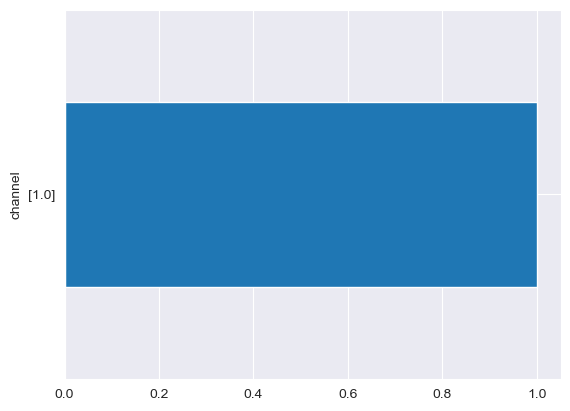

In [83]:
channel_importances_rf = feature_importances_rf.abs().groupby("channel").sum()
ax = channel_importances_rf.plot(kind="barh")

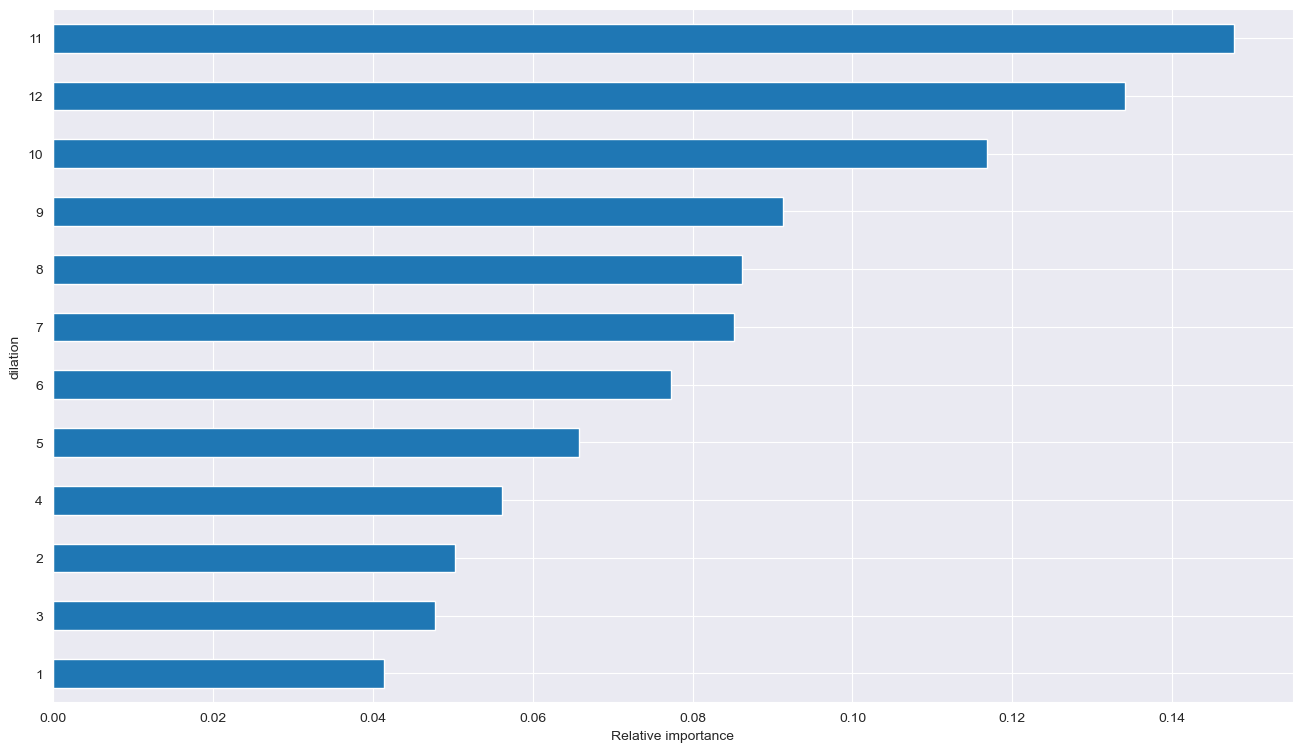

In [84]:
dilation_importances_rf = feature_importances_rf.groupby("dilation").sum().sort_values()
ax = dilation_importances_rf.plot(kind="barh", figsize=(16, 9), xlabel="Relative importance")

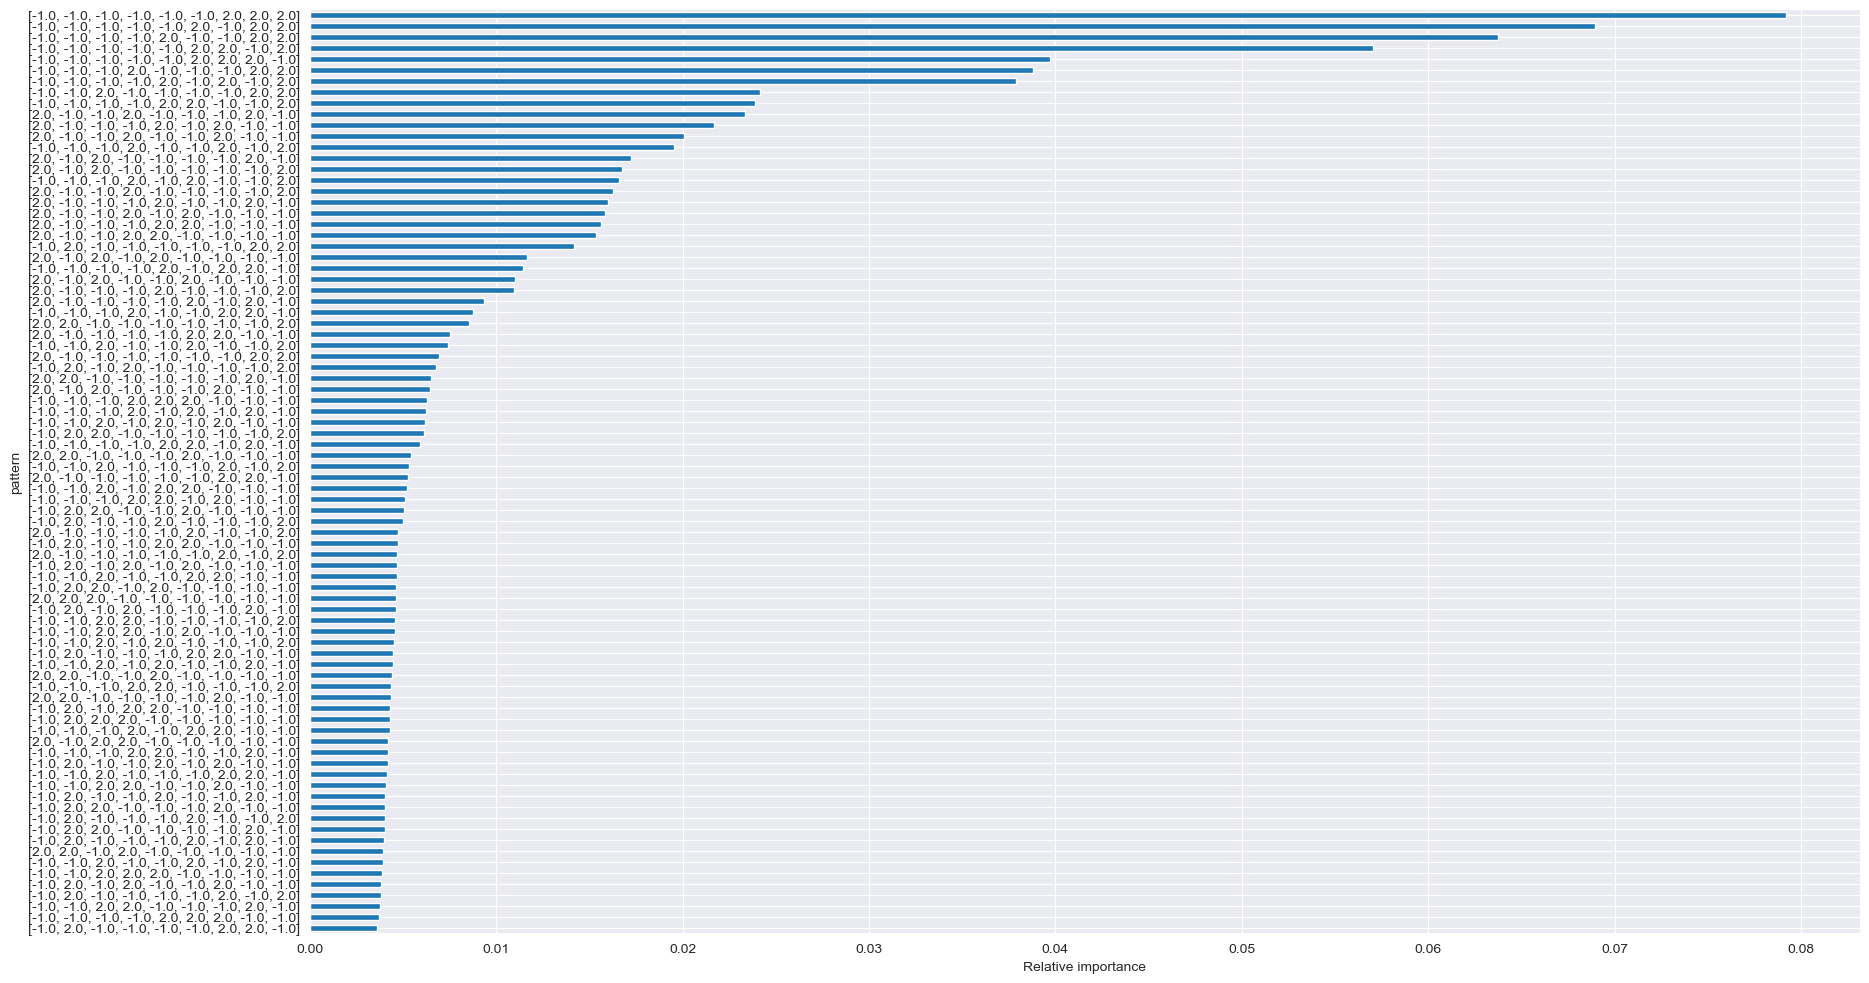

In [85]:
pattern_importances_ef = feature_importances_rf.groupby("pattern").sum().sort_values()
ax = pattern_importances_ef.plot(kind="barh", figsize=(20,12), xlabel="Relative importance")

## Prediction head (Decision Tree Classifier)

In [86]:
# Initialize the RandomForestClassifier
model_dt = DecisionTreeClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [100, 200],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model_dt, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(embed_train_df, y_train_np)

# Get the cross-validation scores
cv_scores_dt = grid_search.cv_results_['mean_test_score']

# Get the best model
best_model_dt = grid_search.best_estimator_

# Print cross-validation scores and the best model
print("Cross-validation scores:", cv_scores_dt)
print("Best model:", best_model_dt)

Cross-validation scores: [0.80715497 0.81457875 0.82063649 0.81379826 0.81418813 0.81282132
 0.81614564 0.81829236]
Best model: DecisionTreeClassifier(max_depth=100, min_samples_leaf=2)


In [87]:
pred_train_dt = best_model_dt.predict(embed_train_df)
acc_train_dt = accuracy_score(y_train_np, pred_train_dt)

In [88]:
print("Accuracy:", accuracy_score(y_train_np, pred_train_dt))
print("Classification Report:\n", classification_report(y_train_np, pred_train_dt))

Accuracy: 0.9861273935130911
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2970
           1       1.00      0.97      0.98      2148

    accuracy                           0.99      5118
   macro avg       0.99      0.98      0.99      5118
weighted avg       0.99      0.99      0.99      5118



[[2962    8]
 [  63 2085]]


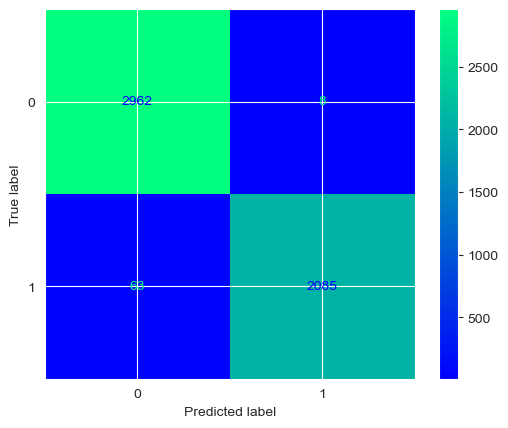

In [89]:
conf_matrix_dt_train = confusion_matrix(y_train_np, pred_train_dt)
print(conf_matrix_dt_train)
p = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt_train)
p.plot(cmap='winter')

In [90]:
pred_test_dt = best_model_dt.predict(embed_test_df)
acc_test_dt = accuracy_score(y_test_np, pred_test_dt)

In [91]:
print("Accuracy:", accuracy_score(y_test_np, pred_test_dt))
print("Classification Report:\n", classification_report(y_test_np, pred_test_dt))

Accuracy: 0.8277717976318623
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       523
           1       0.82      0.77      0.80       406

    accuracy                           0.83       929
   macro avg       0.83      0.82      0.82       929
weighted avg       0.83      0.83      0.83       929



[[455  68]
 [ 92 314]]


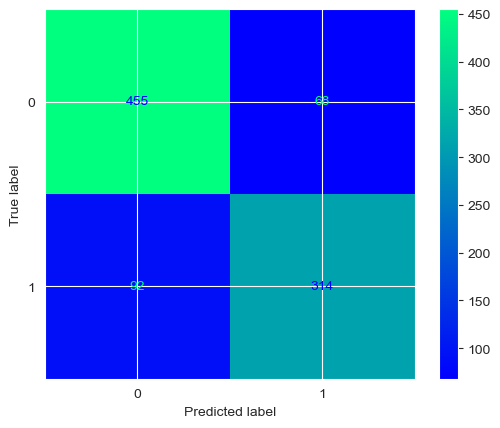

In [92]:
conf_matrix_test_dt = confusion_matrix(y_test_np, pred_test_dt)
print(conf_matrix_test_dt)
p = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test_dt)
p.plot(cmap='winter')

In [ ]:
report_dt_xr = classification_report(y_test_np, pred_test_dt, output_dict=True)
df_report_dt_xr = pd.DataFrame(report_rf_xr).transpose()

# Converte il DataFrame in formato LaTeX
latex_report = df_report_dt_xr.to_latex()

# Stampa il report in formato LaTeX
print(latex_report)

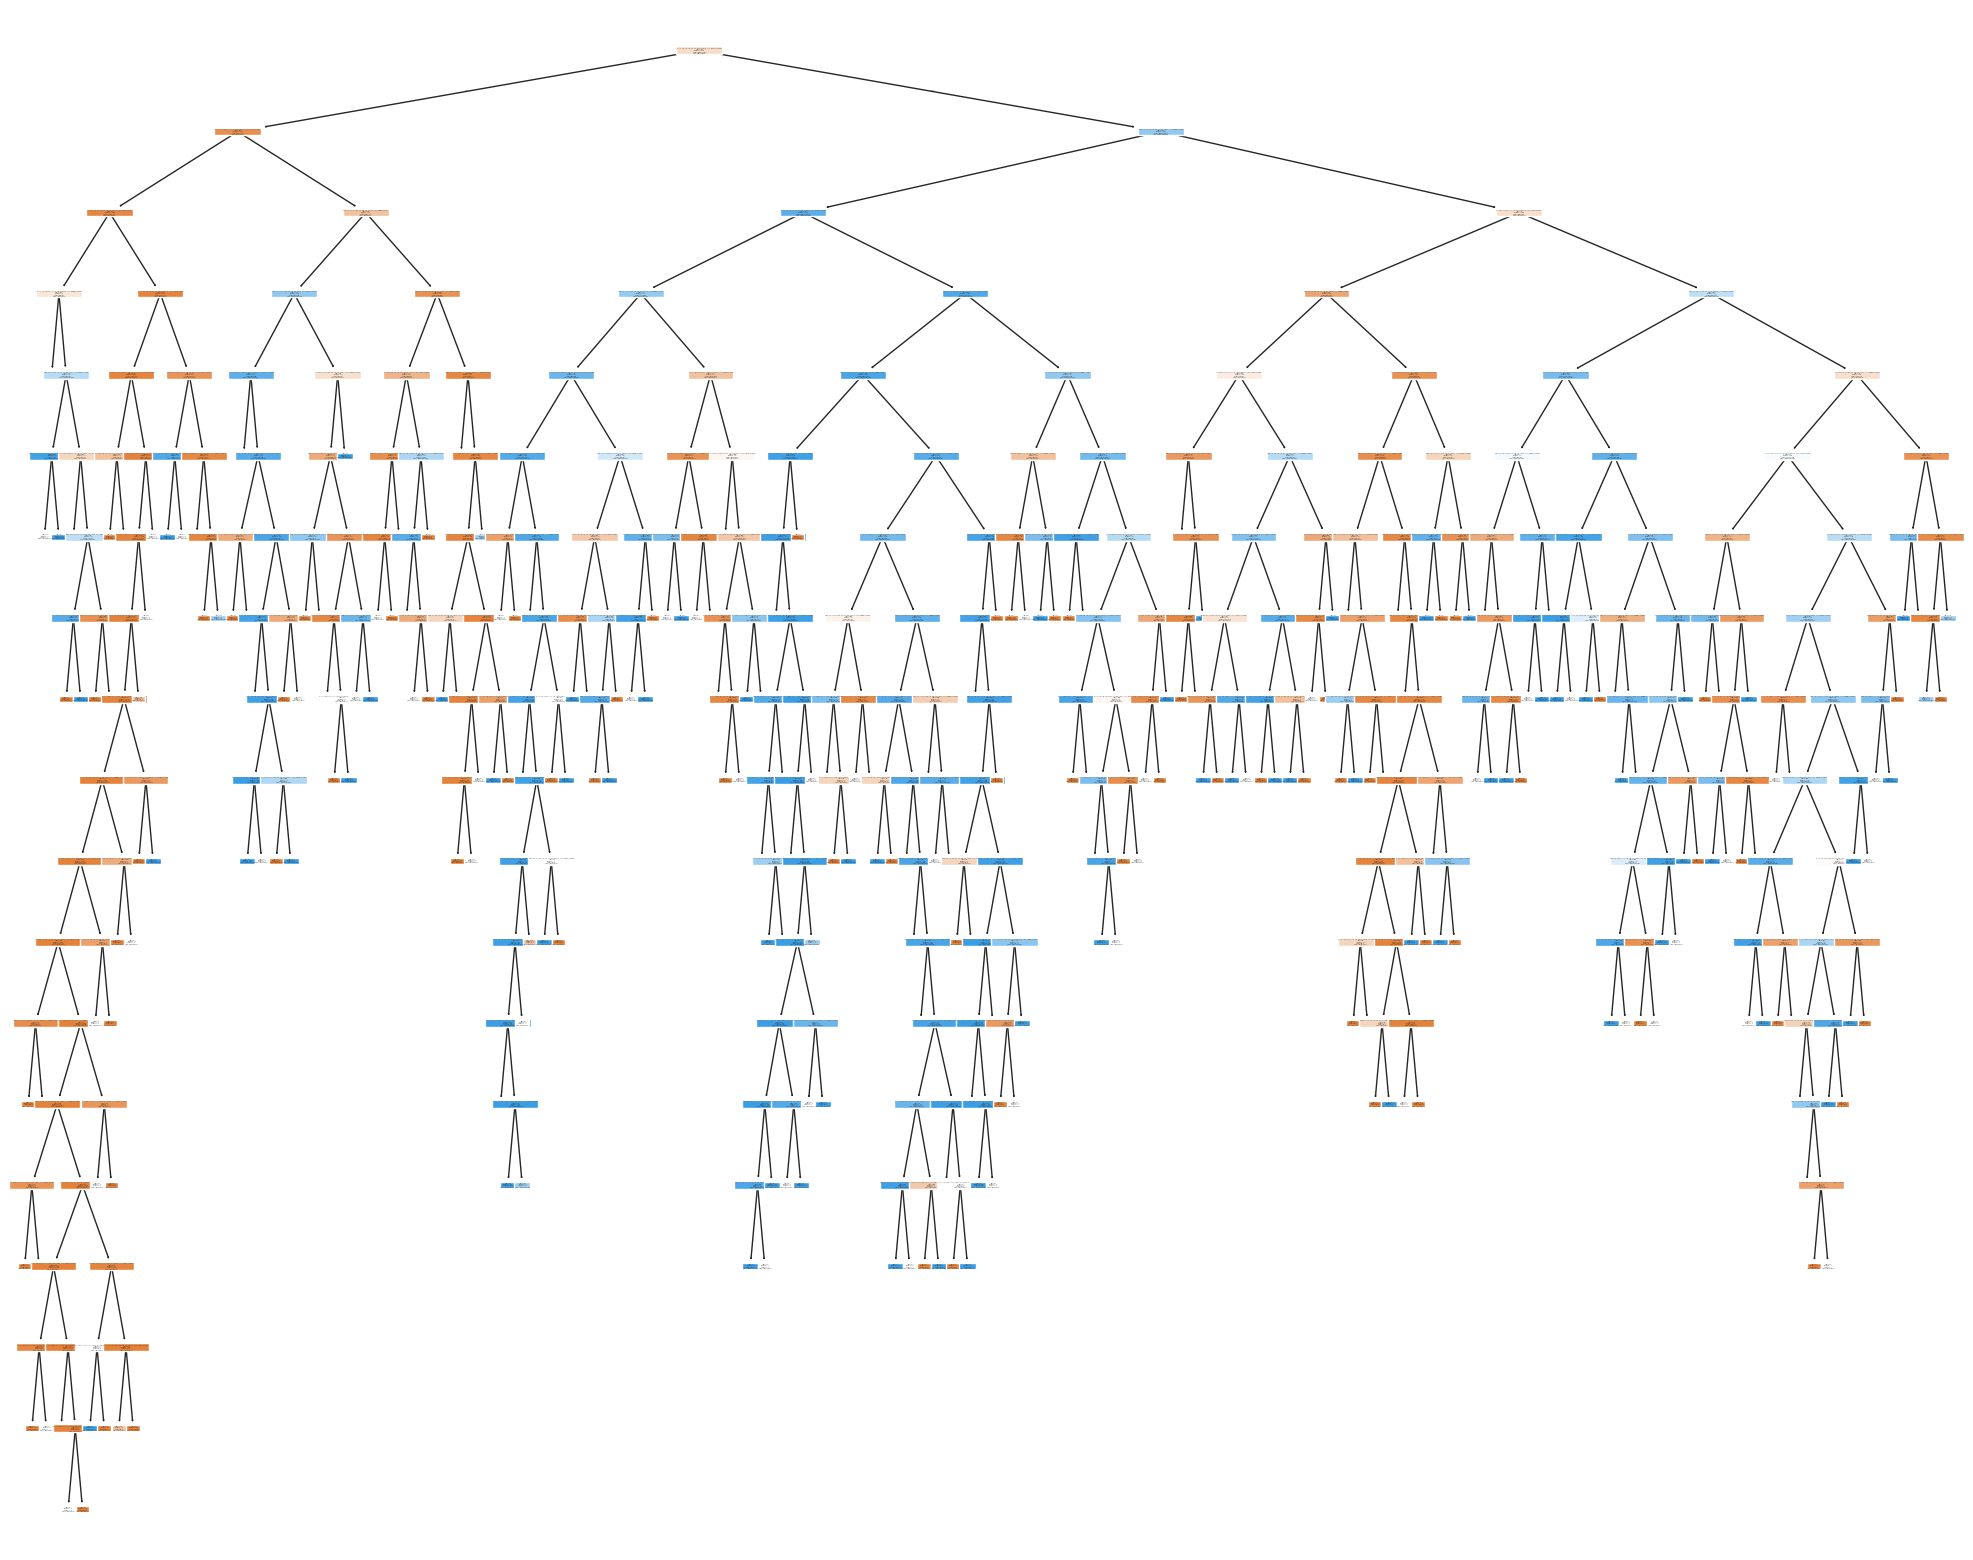

In [93]:
# Class names
class_names = ["BLASTO NY", "NO BLASTO NY"]
fig = plt.figure(figsize=(25,20))
_ = plot_tree(best_model_dt, feature_names=feature_names, class_names=class_names, filled=True)

In [94]:
# Save the Random Forest model
dump(best_model_dt, 'models/model_XRocket_dt.joblib')

['models/model_XRocket_dt.joblib']

## Feature Importances (Decision Tree Classifier)

In [95]:
feature_importances_dt = pd.Series(data=best_model_dt.feature_importances_, index=feature_names)

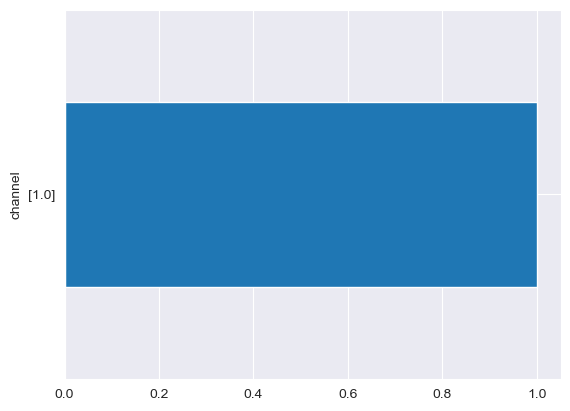

In [96]:
channel_importances_dt = feature_importances_dt.abs().groupby("channel").sum()
ax = channel_importances_dt.plot(kind="barh")

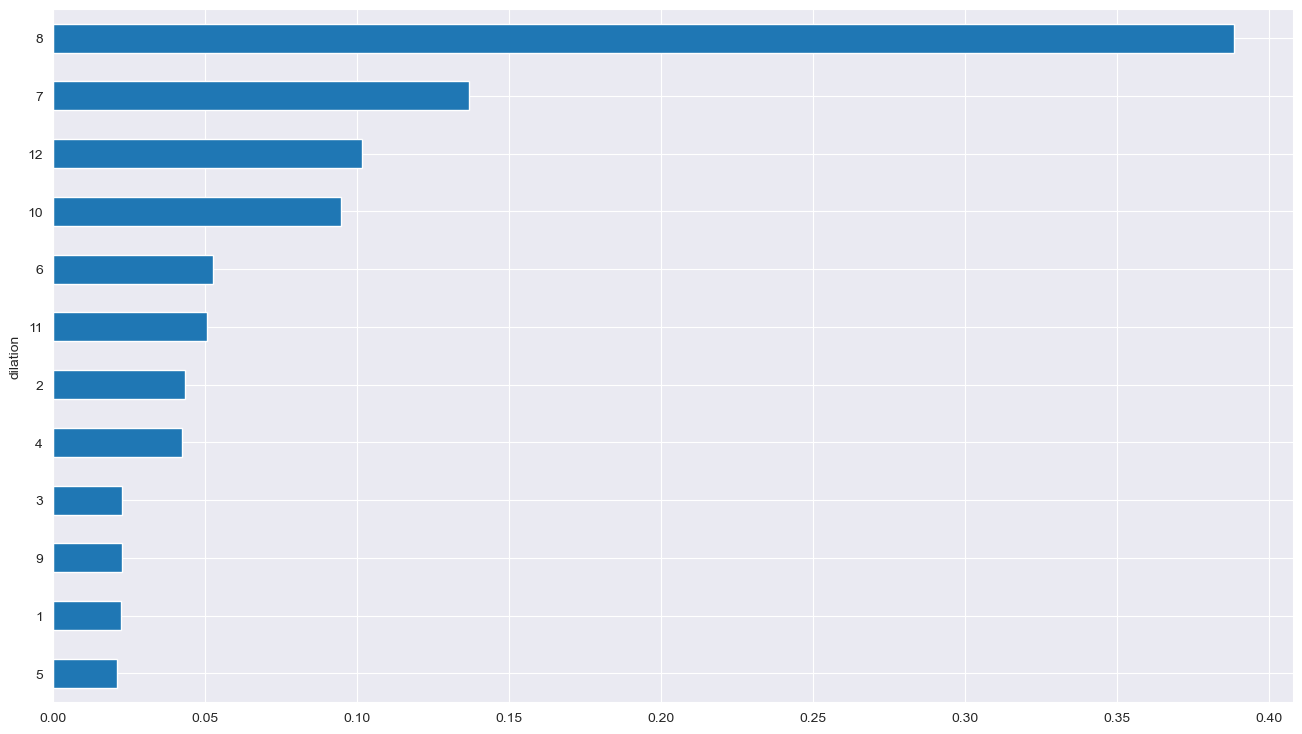

In [97]:
dilation_importances_dt = feature_importances_dt.groupby("dilation").sum().sort_values()
ax = dilation_importances_dt.plot(kind="barh", figsize=(16,9))

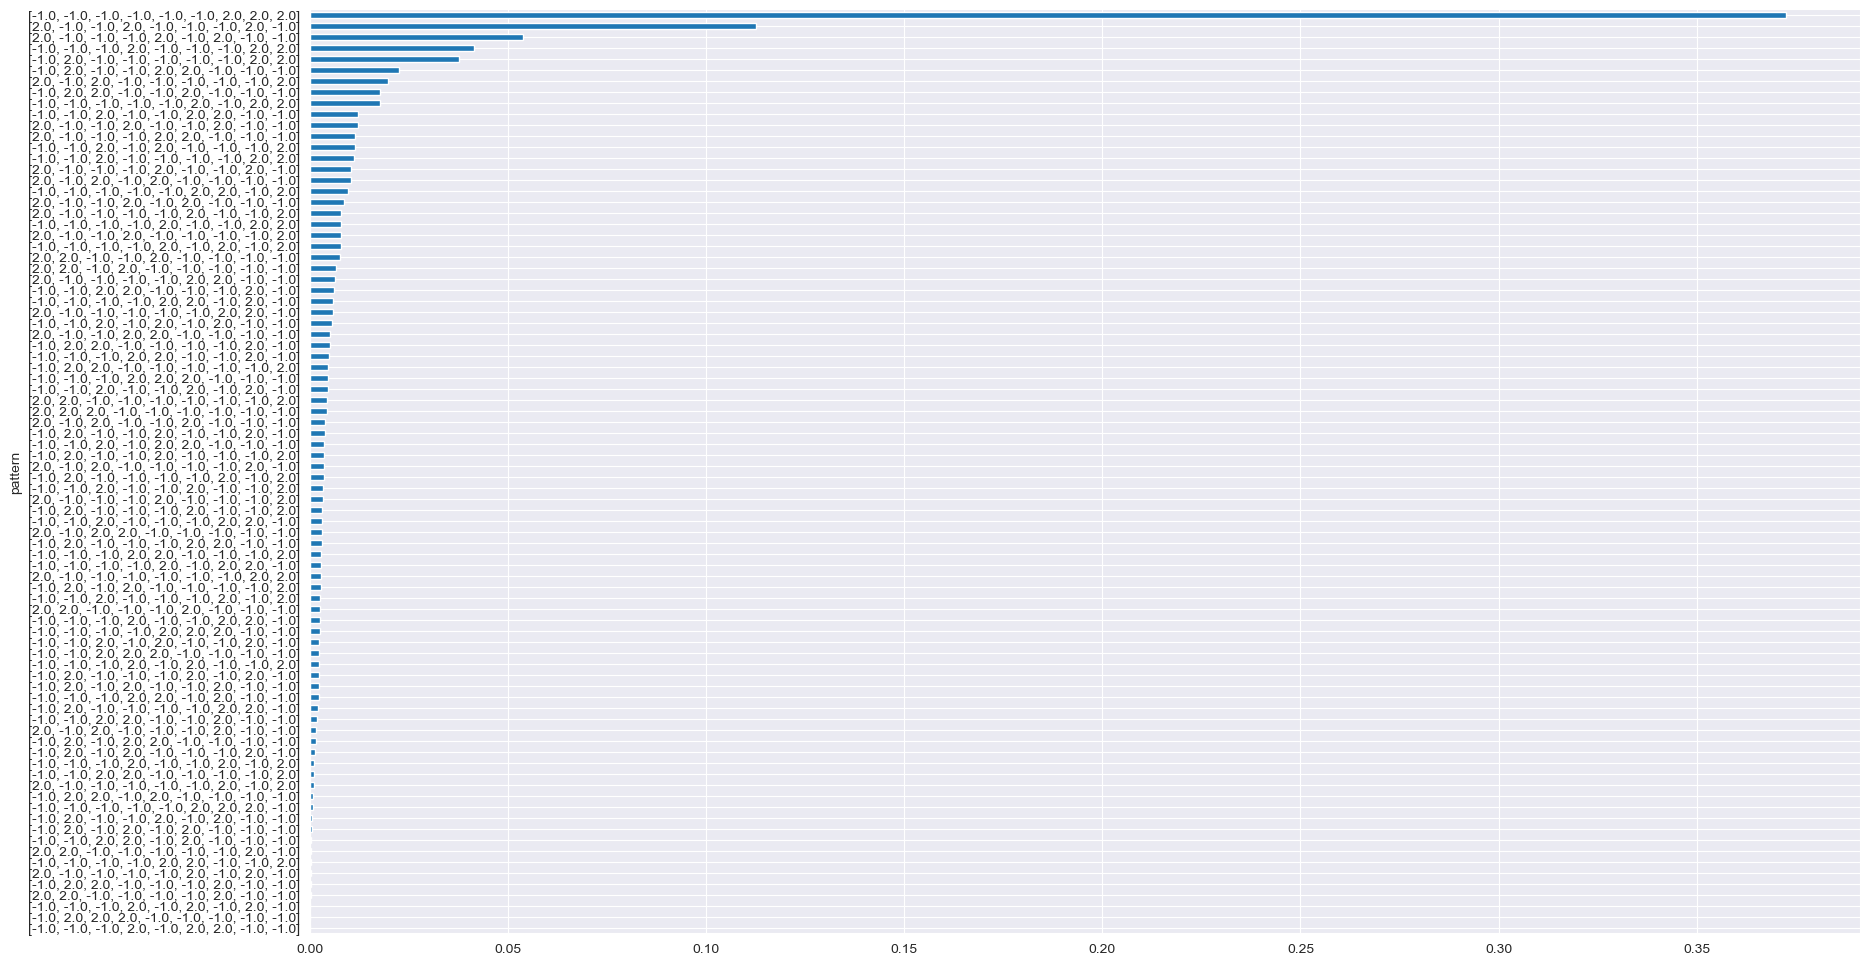

In [98]:
pattern_importances_dt = feature_importances_dt.groupby("pattern").sum().sort_values()
ax = pattern_importances_dt.plot(kind="barh", figsize=(20,12))

In [99]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the feature names
feature_names = list(embed_train_df.columns)

# Class names
class_names = ["BLASTO NY", "NO BLASTO NY"]

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(embed_train_df.values, feature_names=feature_names, class_names=class_names, mode='classification')

# Explain a specific instance from the test set
instance_index = 0  # Change this index to explain different instances
exp = explainer.explain_instance(embed_test_df.iloc[instance_index].values, best_model_rf.predict_proba, num_features=10)

# Plot the explanation
exp.show_in_notebook(show_table=True)